In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

!pip install plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import numpy as np
from scipy.stats import shapiro, normaltest, probplot

from statsmodels.tsa.seasonal import seasonal_decompose

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
%run "variables.py"
%run "functions.ipynb"

In [5]:
# df = pd.read_csv(f'{DATA_DIR}/pred_maint_timeseries_with_failures.csv')
df = pd.read_csv(f'{DATA_DIR}/pred_maint_year_outliers_nulls.csv')
display(df.head())

,machineid,datetimestamp,enginegastemperature1,enginegastemperature2,enginegastemperature3,enginegastemperature4,enginegastemperature5,enginegastemperature6,pressure
0,1,2025-01-01 00:00:00,302.483571,385.408617,303.238443,307.615149,298.829233,298.829315,103.158426
1,1,2025-01-01 00:10:00,303.837174,300.111109,297.861035,297.340913,299.412622,301.110395,98.464047
2,1,2025-01-01 00:20:00,299.877724,301.777757,302.085056,304.162309,298.533004,299.850807,100.190252
3,1,2025-01-01 00:30:00,303.323272,303.895963,294.494511,305.651141,301.865595,298.067635,97.682460
4,1,2025-01-01 00:40:00,297.766293,NaN,301.614999,NaN,289.108329,294.780518,100.345387


In [6]:

df.drop(columns=['machineid'])
df = df.set_index('datetimestamp')
display(df.head())

,machineid,enginegastemperature1,enginegastemperature2,enginegastemperature3,enginegastemperature4,enginegastemperature5,enginegastemperature6,pressure
datetimestamp,,,,,,,,
2025-01-01 00:00:00,1,302.483571,385.408617,303.238443,307.615149,298.829233,298.829315,103.158426
2025-01-01 00:10:00,1,303.837174,300.111109,297.861035,297.340913,299.412622,301.110395,98.464047
2025-01-01 00:20:00,1,299.877724,301.777757,302.085056,304.162309,298.533004,299.850807,100.190252
2025-01-01 00:30:00,1,303.323272,303.895963,294.494511,305.651141,301.865595,298.067635,97.682460
2025-01-01 00:40:00,1,297.766293,NaN,301.614999,NaN,289.108329,294.780518,100.345387


In [9]:
df.duplicated().any

<bound method Series.any of datetimestamp
2025-01-01 00:00:00    False
2025-01-01 00:10:00    False
2025-01-01 00:20:00    False
2025-01-01 00:30:00    False
2025-01-01 00:40:00    False
                       ...  
2025-12-31 23:10:00    False
2025-12-31 23:20:00    False
2025-12-31 23:30:00    False
2025-12-31 23:40:00    False
2025-12-31 23:50:00    False
Length: 262800, dtype: bool>

In [10]:
# Check for duplicates in the dataframe
print(f"Number of duplicate rows: {df.duplicated().sum()}")
print(f"Total rows before dropping duplicates: {len(df)}")

# Drop duplicates
df = df.drop_duplicates()

print(f"Total rows after dropping duplicates: {len(df)}")
display(df.head())

Number of duplicate rows: 0
Total rows before dropping duplicates: 262800
Total rows after dropping duplicates: 262800


,machineid,enginegastemperature1,enginegastemperature2,enginegastemperature3,enginegastemperature4,enginegastemperature5,enginegastemperature6,pressure
datetimestamp,,,,,,,,
2025-01-01 00:00:00,1,302.483571,385.408617,303.238443,307.615149,298.829233,298.829315,103.158426
2025-01-01 00:10:00,1,303.837174,300.111109,297.861035,297.340913,299.412622,301.110395,98.464047
2025-01-01 00:20:00,1,299.877724,301.777757,302.085056,304.162309,298.533004,299.850807,100.190252
2025-01-01 00:30:00,1,303.323272,303.895963,294.494511,305.651141,301.865595,298.067635,97.682460
2025-01-01 00:40:00,1,297.766293,NaN,301.614999,NaN,289.108329,294.780518,100.345387


# Features

Create features to perform Z score model in time series dataframe df for anomaly detection

In [11]:
from sklearn.preprocessing import StandardScaler

# Create features for anomaly detection using Z-score and rolling statistics

# Create a copy of the dataframe for feature engineering
df_with_features = df.copy()

# Remove machineid column as it's not needed for anomaly detection
df_with_features = df_with_features.drop(columns=['machineid'])

# 1. Calculate Z-scores for each sensor
sensor_cols = ['enginegastemperature1', 'enginegastemperature2', 'enginegastemperature3', 
               'enginegastemperature4', 'enginegastemperature5', 'enginegastemperature6', 'pressure']

# Calculate Z-scores for each column
for col in sensor_cols:
    if col in df_with_features.columns:
        mean_val = df_with_features[col].mean()
        std_val = df_with_features[col].std()
        df_with_features[f'{col}_zscore'] = (df_with_features[col] - mean_val) / std_val

# 2. Rolling window features (using 10 time periods as window)
window_size = 10

for col in sensor_cols:
    if col in df_with_features.columns:
        # Rolling mean and std
        df_with_features[f'{col}_rolling_mean'] = df_with_features[col].rolling(window=window_size).mean()
        df_with_features[f'{col}_rolling_std'] = df_with_features[col].rolling(window=window_size).std()
        
        # Rolling min and max
        df_with_features[f'{col}_rolling_min'] = df_with_features[col].rolling(window=window_size).min()
        df_with_features[f'{col}_rolling_max'] = df_with_features[col].rolling(window=window_size).max()
        
        # Deviation from rolling mean
        df_with_features[f'{col}_dev_from_rolling_mean'] = df_with_features[col] - df_with_features[f'{col}_rolling_mean']

# 3. Rate of change features
for col in sensor_cols:
    if col in df_with_features.columns:
        # First difference (rate of change)
        df_with_features[f'{col}_diff'] = df_with_features[col].diff()
        
        # Second difference (acceleration)
        df_with_features[f'{col}_diff2'] = df_with_features[f'{col}_diff'].diff()

# 4. Cross-sensor features
temp_cols = [col for col in sensor_cols if 'temperature' in col]

# Temperature sensor correlations and differences
if len(temp_cols) >= 2:
    # Mean temperature across all sensors
    df_with_features['mean_temperature'] = df_with_features[temp_cols].mean(axis=1)
    
    # Standard deviation across temperature sensors
    df_with_features['std_temperature'] = df_with_features[temp_cols].std(axis=1)
    
    # Range (max - min) across temperature sensors
    df_with_features['range_temperature'] = df_with_features[temp_cols].max(axis=1) - df_with_features[temp_cols].min(axis=1)

# 5. Statistical features for anomaly detection
# Maximum absolute Z-score across all sensors
zscore_cols = [col for col in df_with_features.columns if '_zscore' in col]
df_with_features['max_abs_zscore'] = df_with_features[zscore_cols].abs().max(axis=1)

# Count of sensors with high Z-scores
df_with_features['high_zscore_count_2sigma'] = (df_with_features[zscore_cols].abs() > 2).sum(axis=1)
df_with_features['high_zscore_count_3sigma'] = (df_with_features[zscore_cols].abs() > 3).sum(axis=1)

# 6. Anomaly flags based on Z-scores
df_with_features['anomaly_flag_2sigma'] = (df_with_features['max_abs_zscore'] > 2).astype(int)
df_with_features['anomaly_flag_3sigma'] = (df_with_features['max_abs_zscore'] > 3).astype(int)

# 7. Time-based features
# Ensure the index is datetime type and extract time components
df_with_features.index = pd.to_datetime(df_with_features.index)
df_with_features['hour'] = df_with_features.index.hour
df_with_features['day_of_week'] = df_with_features.index.dayofweek
df_with_features['month'] = df_with_features.index.month

# Store the dataframe with Z-score features for later use
df_with_zscore_features = df_with_features.copy()

print("Features created successfully!")
print(f"Original columns: {len(df.columns)}")
print(f"Total columns after feature engineering: {len(df_with_features.columns)}")
print(f"New feature columns: {len(df_with_features.columns) - len(df.columns)}")

# Display sample of new features
feature_sample = df_with_features[['max_abs_zscore', 'high_zscore_count_2sigma', 'high_zscore_count_3sigma', 
                                   'anomaly_flag_2sigma', 'anomaly_flag_3sigma', 'mean_temperature', 
                                   'std_temperature', 'range_temperature']].head(10)
print("\nSample of created features:")
display(feature_sample)

# Show anomaly statistics
print(f"\nAnomaly Statistics:")
print(f"Total data points: {len(df_with_features)}")
print(f"Anomalies (2σ threshold): {df_with_features['anomaly_flag_2sigma'].sum()} ({df_with_features['anomaly_flag_2sigma'].mean()*100:.2f}%)")
print(f"Anomalies (3σ threshold): {df_with_features['anomaly_flag_3sigma'].sum()} ({df_with_features['anomaly_flag_3sigma'].mean()*100:.2f}%)")

Features created successfully!
Original columns: 8
Total columns after feature engineering: 74
New feature columns: 66

Sample of created features:


,max_abs_zscore,high_zscore_count_2sigma,high_zscore_count_3sigma,anomaly_flag_2sigma,anomaly_flag_3sigma,mean_temperature,std_temperature,range_temperature
datetimestamp,,,,,,,,
2025-01-01 00:00:00,8.301410,1,1,1,1,316.067388,34.126393,86.579384
2025-01-01 00:10:00,0.766114,0,0,0,0,299.945541,2.363995,6.496261
2025-01-01 00:20:00,0.318559,0,0,0,0,301.047776,2.021632,5.629305
2025-01-01 00:30:00,1.156868,0,0,0,0,301.216353,4.166674,11.156630
2025-01-01 00:40:00,1.174450,0,0,0,0,295.817535,5.275639,12.506670
2025-01-01 00:50:00,1.218307,0,0,0,0,305.109845,4.736676,11.962620
2025-01-01 01:00:00,1.029949,0,0,0,0,295.405189,4.214635,12.559909
2025-01-01 01:10:00,0.767805,0,0,0,0,302.464903,3.304153,7.747045
2025-01-01 01:20:00,0.940785,0,0,0,0,301.413205,5.728850,17.054019



Anomaly Statistics:
Total data points: 262800
Anomalies (2σ threshold): 30218 (11.50%)
Anomalies (3σ threshold): 20491 (7.80%)


# Model

using the features created above, we can now train an Z score model to detect anomalies in the time series data. Show the confusion matrix of the anomalies detected by the Z score model and the defined failure flags for temperature sensors. Add evaluation of the model.

Available failure columns: []
Dataset size after removing NaN: 262800
Actual failures: 19803
Z-score anomalies (3σ): 20491
Z-score anomalies (2σ): 30218

=== Z-Score Model (3σ threshold) ===
Confusion Matrix:
                Predicted
                No Failure  Failure
Actual No Failure    242309       688
Actual Failure            0     19803

Classification Report:
              precision    recall  f1-score   support

  No Failure       1.00      1.00      1.00    242997
     Failure       0.97      1.00      0.98     19803

    accuracy                           1.00    262800
   macro avg       0.98      1.00      0.99    262800
weighted avg       1.00      1.00      1.00    262800


=== Z-Score Model (2σ threshold) ===
Confusion Matrix:
                Predicted
                No Failure  Failure
Actual No Failure    232582     10415
Actual Failure            0     19803

Classification Report:
              precision    recall  f1-score   support

  No Failure       1.00      

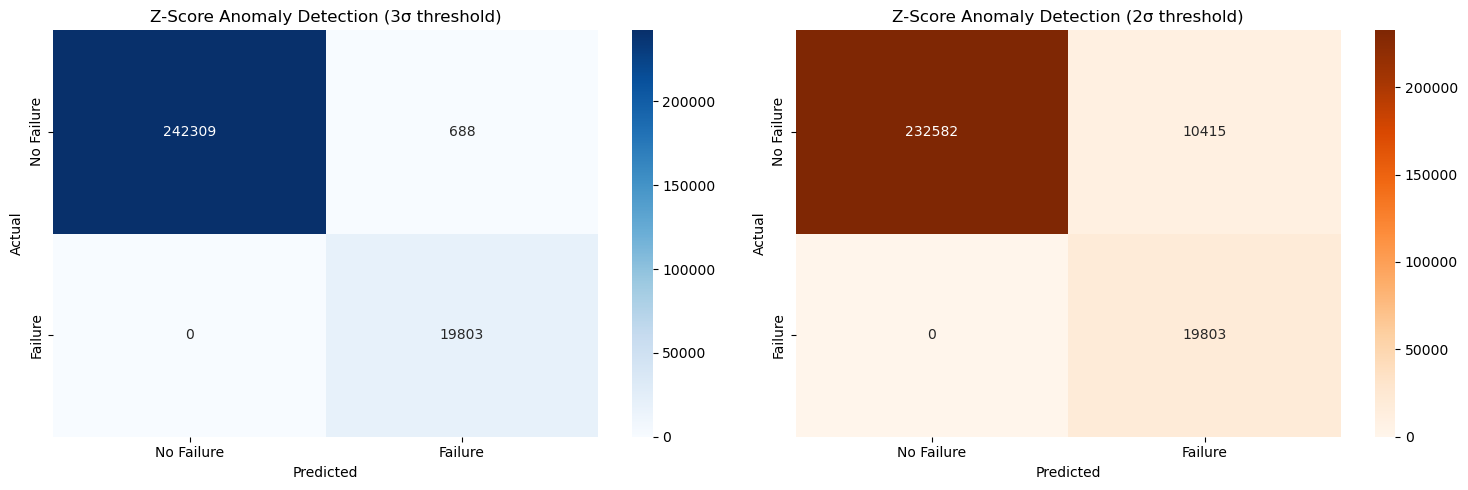

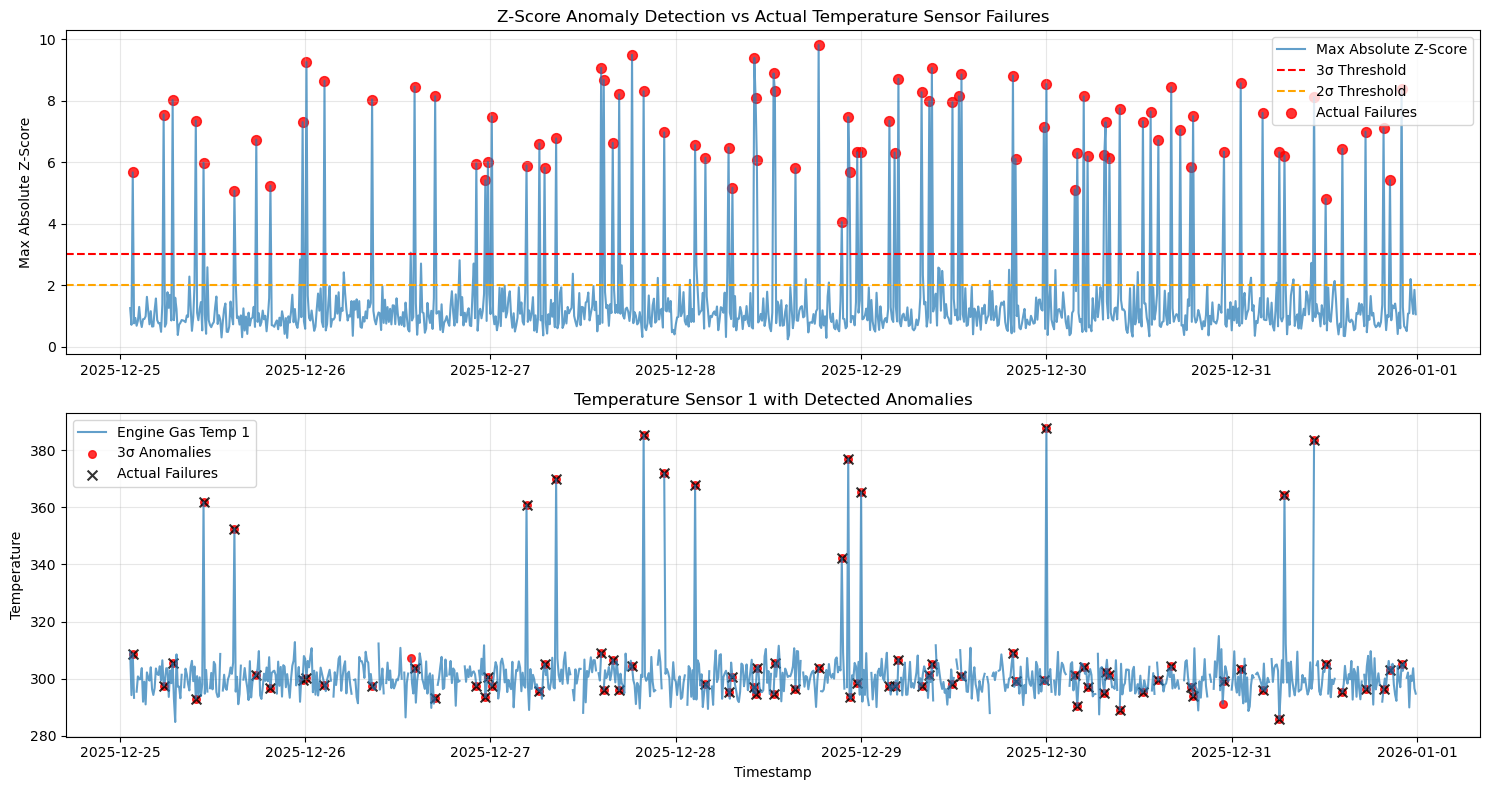

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve

# First, let's check if there are failure flags in the dataset
failure_cols = [col for col in df.columns if 'failure' in col.lower() or 'fault' in col.lower()]
print("Available failure columns:", failure_cols)

# If no failure columns exist, let's create synthetic failure flags based on extreme values
# We'll define failures as extreme outliers (beyond 4 sigma) in temperature sensors
temp_cols = [col for col in df.columns if 'enginegastemperature' in col]

# Create failure flags based on extreme temperature values
df_eval = df_with_features.copy()

# Define temperature sensor failures as values beyond 4 standard deviations
temp_failure_conditions = []
for i, col in enumerate(temp_cols):
    if col in df.columns:
        mean_val = df[col].mean()
        std_val = df[col].std()
        extreme_condition = (abs(df[col] - mean_val) > 4 * std_val)
        # Create a new Series with proper index alignment
        extreme_series = pd.Series(extreme_condition.values, 
                                 index=df_eval.index, 
                                 name=f'temp_failure_{i}')
        temp_failure_conditions.append(extreme_series)

# Combine all temperature sensor failure conditions
if temp_failure_conditions:
    temp_failure_df = pd.concat(temp_failure_conditions, axis=1)
    df_eval['temp_sensor_failure'] = temp_failure_df.any(axis=1).astype(int)
else:
    df_eval['temp_sensor_failure'] = 0

# Use Z-score anomaly flags as predictions
y_true = df_eval['temp_sensor_failure']
y_pred_3sigma = df_eval['anomaly_flag_3sigma']
y_pred_2sigma = df_eval['anomaly_flag_2sigma']

# Remove NaN values for evaluation
valid_mask = ~(y_true.isna() | y_pred_3sigma.isna() | y_pred_2sigma.isna())
y_true_clean = y_true[valid_mask]
y_pred_3sigma_clean = y_pred_3sigma[valid_mask]
y_pred_2sigma_clean = y_pred_2sigma[valid_mask]

print(f"Dataset size after removing NaN: {len(y_true_clean)}")
print(f"Actual failures: {y_true_clean.sum()}")
print(f"Z-score anomalies (3σ): {y_pred_3sigma_clean.sum()}")
print(f"Z-score anomalies (2σ): {y_pred_2sigma_clean.sum()}")

# Create confusion matrices and evaluate models

# Evaluation for 3-sigma threshold
cm_3sigma = confusion_matrix(y_true_clean, y_pred_3sigma_clean)
print("\n=== Z-Score Model (3σ threshold) ===")
print("Confusion Matrix:")
print("                Predicted")
print("                No Failure  Failure")
print(f"Actual No Failure  {cm_3sigma[0,0]:8d}    {cm_3sigma[0,1]:6d}")
print(f"Actual Failure     {cm_3sigma[1,0]:8d}    {cm_3sigma[1,1]:6d}")

print("\nClassification Report:")
print(classification_report(y_true_clean, y_pred_3sigma_clean, 
                          target_names=['No Failure', 'Failure']))

# Evaluation for 2-sigma threshold
cm_2sigma = confusion_matrix(y_true_clean, y_pred_2sigma_clean)
print("\n=== Z-Score Model (2σ threshold) ===")
print("Confusion Matrix:")
print("                Predicted")
print("                No Failure  Failure")
print(f"Actual No Failure  {cm_2sigma[0,0]:8d}    {cm_2sigma[0,1]:6d}")
print(f"Actual Failure     {cm_2sigma[1,0]:8d}    {cm_2sigma[1,1]:6d}")

print("\nClassification Report:")
print(classification_report(y_true_clean, y_pred_2sigma_clean, 
                          target_names=['No Failure', 'Failure']))

# Calculate additional metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    return {
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1,
        'Accuracy': accuracy
    }

# Compare metrics
metrics_3sigma = calculate_metrics(y_true_clean, y_pred_3sigma_clean)
metrics_2sigma = calculate_metrics(y_true_clean, y_pred_2sigma_clean)

print("\n=== Model Comparison ===")
print("Metric               3σ Threshold    2σ Threshold")
print("-" * 50)
for metric in metrics_3sigma.keys():
    print(f"{metric:<20} {metrics_3sigma[metric]:>12.4f}    {metrics_2sigma[metric]:>12.4f}")

# Visualize confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot confusion matrix for 3-sigma
sns.heatmap(cm_3sigma, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Z-Score Anomaly Detection (3σ threshold)')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_xticklabels(['No Failure', 'Failure'])
ax1.set_yticklabels(['No Failure', 'Failure'])

# Plot confusion matrix for 2-sigma
sns.heatmap(cm_2sigma, annot=True, fmt='d', cmap='Oranges', ax=ax2)
ax2.set_title('Z-Score Anomaly Detection (2σ threshold)')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_xticklabels(['No Failure', 'Failure'])
ax2.set_yticklabels(['No Failure', 'Failure'])

plt.tight_layout()
plt.show()

# Plot time series with anomalies and failures
plt.figure(figsize=(15, 8))

# Sample data for visualization (last 1000 points)
sample_size = 1000
sample_data = df_eval.tail(sample_size)

plt.subplot(2, 1, 1)
plt.plot(sample_data.index, sample_data['max_abs_zscore'], label='Max Absolute Z-Score', alpha=0.7)
plt.axhline(y=3, color='red', linestyle='--', label='3σ Threshold')
plt.axhline(y=2, color='orange', linestyle='--', label='2σ Threshold')
plt.scatter(sample_data[sample_data['temp_sensor_failure']==1].index, 
           sample_data[sample_data['temp_sensor_failure']==1]['max_abs_zscore'], 
           color='red', s=50, label='Actual Failures', alpha=0.8)
plt.title('Z-Score Anomaly Detection vs Actual Temperature Sensor Failures')
plt.ylabel('Max Absolute Z-Score')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(sample_data.index, sample_data['enginegastemperature1'], label='Engine Gas Temp 1', alpha=0.7)
plt.scatter(sample_data[sample_data['anomaly_flag_3sigma']==1].index,
           sample_data[sample_data['anomaly_flag_3sigma']==1]['enginegastemperature1'],
           color='red', s=30, label='3σ Anomalies', alpha=0.8)
plt.scatter(sample_data[sample_data['temp_sensor_failure']==1].index,
           sample_data[sample_data['temp_sensor_failure']==1]['enginegastemperature1'],
           color='black', s=50, marker='x', label='Actual Failures', alpha=0.8)
plt.title('Temperature Sensor 1 with Detected Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()